# Retinal Vessel Extraction Sauvola vs Niblack

In [22]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.filters import threshold_niblack, threshold_sauvola

In [ ]:
image_dir = r"C:\Users\umbar\OneDrive\Documents\Deep Learning For Medical Images\project1\Deep-Learning-for-Medical-Image-Processing\Project3_Retinal_Vessel_Extraction_Sauvola_vs_Niblack\data\DRIVE\training\images"
mask_dir = r"C:\Users\umbar\OneDrive\Documents\Deep Learning For Medical Images\project1\Deep-Learning-for-Medical-Image-Processing\Project3_Retinal_Vessel_Extraction_Sauvola_vs_Niblack\data\DRIVE\training\1st_manual"
fov_dir = r"C:\Users\umbar\OneDrive\Documents\Deep Learning For Medical Images\project1\Deep-Learning-for-Medical-Image-Processing\Project3_Retinal_Vessel_Extraction_Sauvola_vs_Niblack\data\DRIVE\training\mask"

print("Total Images:", len(os.listdir(image_dir)))
print("Total Masks:", len(os.listdir(mask_dir)))

Total Images: 20
Total Masks: 20


In [24]:
class DriveThresholdDataset(Dataset):
    def __init__(self, image_dir, mask_dir, fov_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.fov_dir = fov_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        base_name = img_name.split('_')[0]

        mask_name = base_name + "_manual1.gif"
        mask_path = os.path.join(self.mask_dir, mask_name)

        fov_name = base_name + "_training_mask.gif"
        fov_path = os.path.join(self.fov_dir, fov_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        green = image[:, :, 1]

        gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt = (gt > 127).astype(np.uint8)

        fov = cv2.imread(fov_path, cv2.IMREAD_GRAYSCALE)
        fov = (fov > 127).astype(np.uint8)

        return green, gt, fov, img_name

In [27]:
dataset = DriveThresholdDataset(image_dir, mask_dir, fov_dir)

In [28]:
def preprocess_image(green):
    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(green)
    return enhanced

In [29]:
def apply_niblack(image):
    thresh = threshold_niblack(image, window_size=25, k=-0.2)
    binary = image < thresh
    return binary.astype(np.uint8)


In [30]:
def apply_sauvola(image):
    thresh = threshold_sauvola(image, window_size=25, k=0.2)
    binary = image < thresh
    return binary.astype(np.uint8)

In [31]:
def compute_metrics(pred, gt, fov_mask):
    # consider only FOV
    pred = pred[fov_mask == 1]
    gt = gt[fov_mask == 1]

    TP = np.sum((pred == 1) & (gt == 1))
    TN = np.sum((pred == 0) & (gt == 0))
    FP = np.sum((pred == 1) & (gt == 0))
    FN = np.sum((pred == 0) & (gt == 1))

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    dice = 2*TP / (2*TP + FP + FN + 1e-8)

    return sensitivity, specificity, accuracy, dice

In [32]:
def extract_thin_vessels(gt_mask):
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(gt_mask, kernel, iterations=1)
    thin = gt_mask - eroded
    thin = (thin > 0).astype(np.uint8)
    return thin

In [33]:
def thin_vessel_sensitivity(pred, gt, fov_mask):
    thin_gt = extract_thin_vessels(gt)

    pred = pred[fov_mask == 1]
    thin_gt = thin_gt[fov_mask == 1]

    TP = np.sum((pred == 1) & (thin_gt == 1))
    FN = np.sum((pred == 0) & (thin_gt == 1))

    return TP / (TP + FN + 1e-8)

In [34]:
results = {"niblack": [], "sauvola": []}
thin_results = {"niblack": [], "sauvola": []}

for green, gt, fov, name in tqdm(dataset):

    pre = preprocess_image(green)

    pre = pre * fov

    # Apply thresholding
    pred_nib = apply_niblack(pre)
    pred_sau = apply_sauvola(pre)

    pred_nib = pred_nib * fov
    pred_sau = pred_sau * fov

    # Compute metrics
    m_nib = compute_metrics(pred_nib, gt, fov)
    m_sau = compute_metrics(pred_sau, gt, fov)

    t_nib = thin_vessel_sensitivity(pred_nib, gt, fov)
    t_sau = thin_vessel_sensitivity(pred_sau, gt, fov)

    results["niblack"].append(m_nib)
    results["sauvola"].append(m_sau)

    thin_results["niblack"].append(t_nib)
    thin_results["sauvola"].append(t_sau)

100%|██████████| 20/20 [00:01<00:00, 18.09it/s]


In [35]:
def average_metrics(metric_list):
    return np.mean(metric_list, axis=0)

In [43]:
def average_metrics(metric_list):
    return np.mean(metric_list, axis=0)

avg_nib = average_metrics(results["niblack"])
avg_sau = average_metrics(results["sauvola"])

avg_thin_nib = np.mean(thin_results["niblack"])
avg_thin_sau = np.mean(thin_results["sauvola"])

print("===== OVERALL METRICS =====")
print("Niblack - Sensitivity, Specificity, Accuracy, Dice:", avg_nib)
print("Sauvola - Sensitivity, Specificity, Accuracy, Dice:", avg_sau)

print("\n===== THIN VESSEL SENSITIVITY =====")
print("Niblack Thin Sensitivity:", avg_thin_nib)
print("Sauvola Thin Sensitivity:", avg_thin_sau)

===== OVERALL METRICS =====
Niblack - Sensitivity, Specificity, Accuracy, Dice: [0.90568462 0.5393491  0.58486804 0.35272353]
Sauvola - Sensitivity, Specificity, Accuracy, Dice: [0.53869927 0.97263717 0.91772038 0.62039181]

===== THIN VESSEL SENSITIVITY =====
Niblack Thin Sensitivity: 0.8650671682639492
Sauvola Thin Sensitivity: 0.37598353885123853


In [40]:
def show_sample(dataset, index=0, window_size=25, k_nib=-0.2, k_sau=0.2):
    
    green, gt, _, name = dataset[index]
    
    # Preprocess
    pre = preprocess_image(green)
    
    # Apply thresholding
    thresh_nib = threshold_niblack(pre, window_size=window_size, k=k_nib)
    pred_nib = (pre < thresh_nib).astype(np.uint8)

    thresh_sau = threshold_sauvola(pre, window_size=window_size, k=k_sau)
    pred_sau = (pre < thresh_sau).astype(np.uint8)

    # Thin vessels
    thin_gt = extract_thin_vessels(gt)

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Sample: {name}", fontsize=16)

    axes[0,0].imshow(green, cmap='gray')
    axes[0,0].set_title("Green Channel")
    axes[0,0].axis("off")

    axes[0,1].imshow(pre, cmap='gray')
    axes[0,1].set_title("CLAHE Preprocessed")
    axes[0,1].axis("off")

    axes[0,2].imshow(gt, cmap='gray')
    axes[0,2].set_title("Ground Truth")
    axes[0,2].axis("off")

    axes[1,0].imshow(pred_nib, cmap='gray')
    axes[1,0].set_title("Niblack")
    axes[1,0].axis("off")

    axes[1,1].imshow(pred_sau, cmap='gray')
    axes[1,1].set_title("Sauvola")
    axes[1,1].axis("off")

    axes[1,2].imshow(thin_gt, cmap='gray')
    axes[1,2].set_title("Thin Vessels (GT)")
    axes[1,2].axis("off")

    plt.tight_layout()
    plt.show()
    

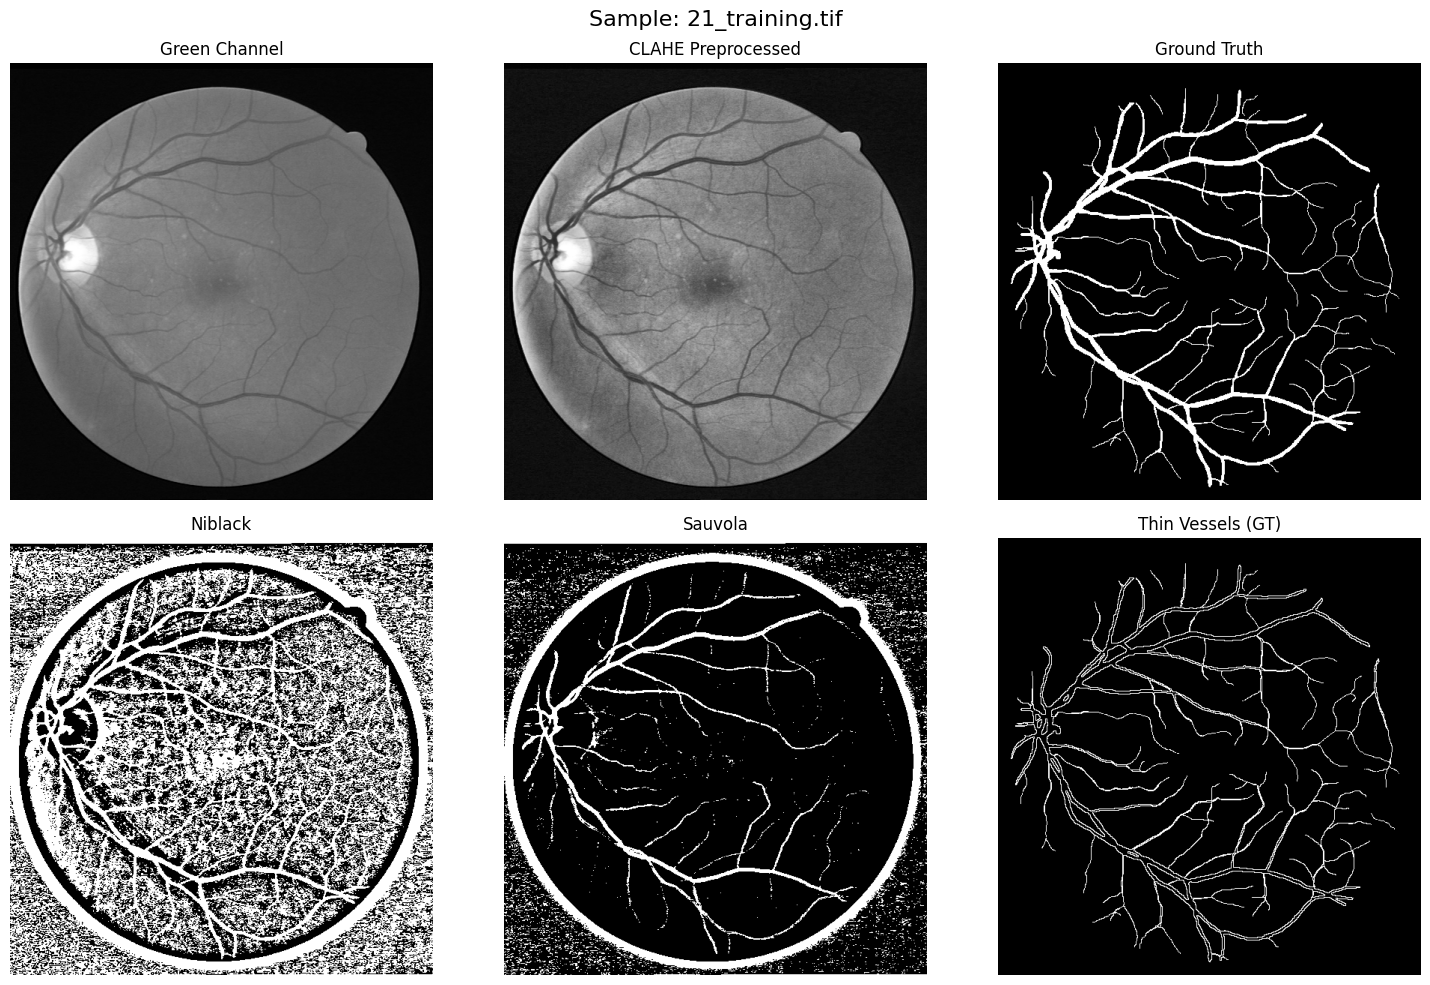

In [41]:
show_sample(dataset, index=0)

## Conclusion — Sauvola vs Niblack for Retinal Vessel Extraction

### Final Results (DRIVE Training Set)

| Method   | Sensitivity | Specificity | Accuracy | Dice Score | Thin Vessel Sensitivity |
|-----------|------------|------------|----------|------------|--------------------------|
| **Niblack** | **0.9057** | 0.5393 | 0.5849 | 0.3527 | **0.8651** |
| **Sauvola** | 0.5387 | **0.9726** | **0.9177** | **0.6204** | 0.3760 |


### Interpretation of Results

#### Overall Segmentation Performance

- **Sauvola achieves significantly higher Specificity (0.97) and Dice score (0.62)**.
- This indicates that Sauvola produces a cleaner segmentation with far fewer false positives.
- The high Dice score confirms better overall balance between precision and recall.

In contrast:

- **Niblack achieves very high Sensitivity (0.90)** but very low Specificity (0.54).
- This means Niblack detects most vessels but also produces substantial background noise.
- The low Dice score (0.35) reflects this over-segmentation.



#### Thin Vessel Detection

- **Niblack strongly outperforms Sauvola in thin vessel sensitivity (0.86 vs 0.37)**.
- This shows that Niblack is much more aggressive in detecting low-contrast, small-width vessels.

This behavior occurs because:

- Niblack directly shifts the threshold using local standard deviation.
- Even small intensity variations allow thin vessels to be detected.

Sauvola, however:

- Normalizes local variance.
- Suppresses low-contrast regions.
- Misses many ultra-thin vessels to avoid noise.

---

The observed behavior reflects a fundamental trade-off:

| Property | Niblack | Sauvola |
|-----------|----------|----------|
| Aggressiveness | High | Moderate |
| Noise Suppression | Poor | Excellent |
| Thin Vessel Recall | High | Low |
| Overall Stability | Low | High |

- **Niblack favors recall**, capturing nearly all vessel structures, including thin ones, but introduces substantial false positives.
- **Sauvola favors precision**, suppressing noise and background artifacts, resulting in higher specificity and Dice score.

Thus, Sauvola provides more balanced and clinically stable segmentation, while Niblack is better suited when maximizing thin vessel detection is the primary objective.


### Final Conclusion

Sauvola demonstrates superior overall segmentation quality on the DRIVE dataset due to its strong background suppression and higher Dice score.

However, Niblack shows significantly better sensitivity for thin vessels, highlighting its effectiveness in detecting subtle low-contrast vascular structures.

This experiment clearly demonstrates the classical precision–recall trade-off in local thresholding methods and shows how variance normalization in **Sauvola improves stability at the cost of thin structure sensitivity**.